In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-04 00:01:49.352066


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 48
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.6418)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.9616)
penalty_target_min tensor(-12.3191) penalty_target_max tensor(6.1955)
train_loss:  -10.310355686950682
valid_loss:  -9.590500329589842
h_min_tilde -12.319111 ell_tilde -10.166384615478515 kappa_tilde 0.0006815623571347406


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.3922739028930664

 2 3.312187433242798

 3 3.1795012950897217

 4 3.3636858463287354

 5 3.1081972122192383

 6 3.3752522468566895

 7 2.6672637462615967

 8 3.239382743835449

 9 3.12107515335083

 10 3.212164878845215

 11 3.176239013671875

 12 3.20693302154541

 13 3.145958662033081

 14 3.098999261856079

 15 2.9684479236602783

 16 3.1174862384796143

 17 3.1047186851501465

 18 3.082932472229004

 19 3.096039056777954

 20 3.048147678375244

 21 3.118201732635498

 22 3.2335851192474365

 23 3.2053420543670654

 24 3.1679699420928955

 25 3.288878917694092

 26 3.257810592651367

 27 2.997814178466797

 28 3.0202713012695312

 29 3.128272771835327

 30 3.031268358230591

 31 3.341874361038208

 32 3.27262282371521

 33 3.317124128341675

 34 3.0624706745147705

 35 3.113084554672241

 36 3.0858383178710938

 37 3.1404552459716797

 38 3.1442203521728516

 39 3.1891040802001953

 40 3.1177985668182373

 41 3.111565113067627

 42 3.1000163555145264

 43 3.089749336242676

 4

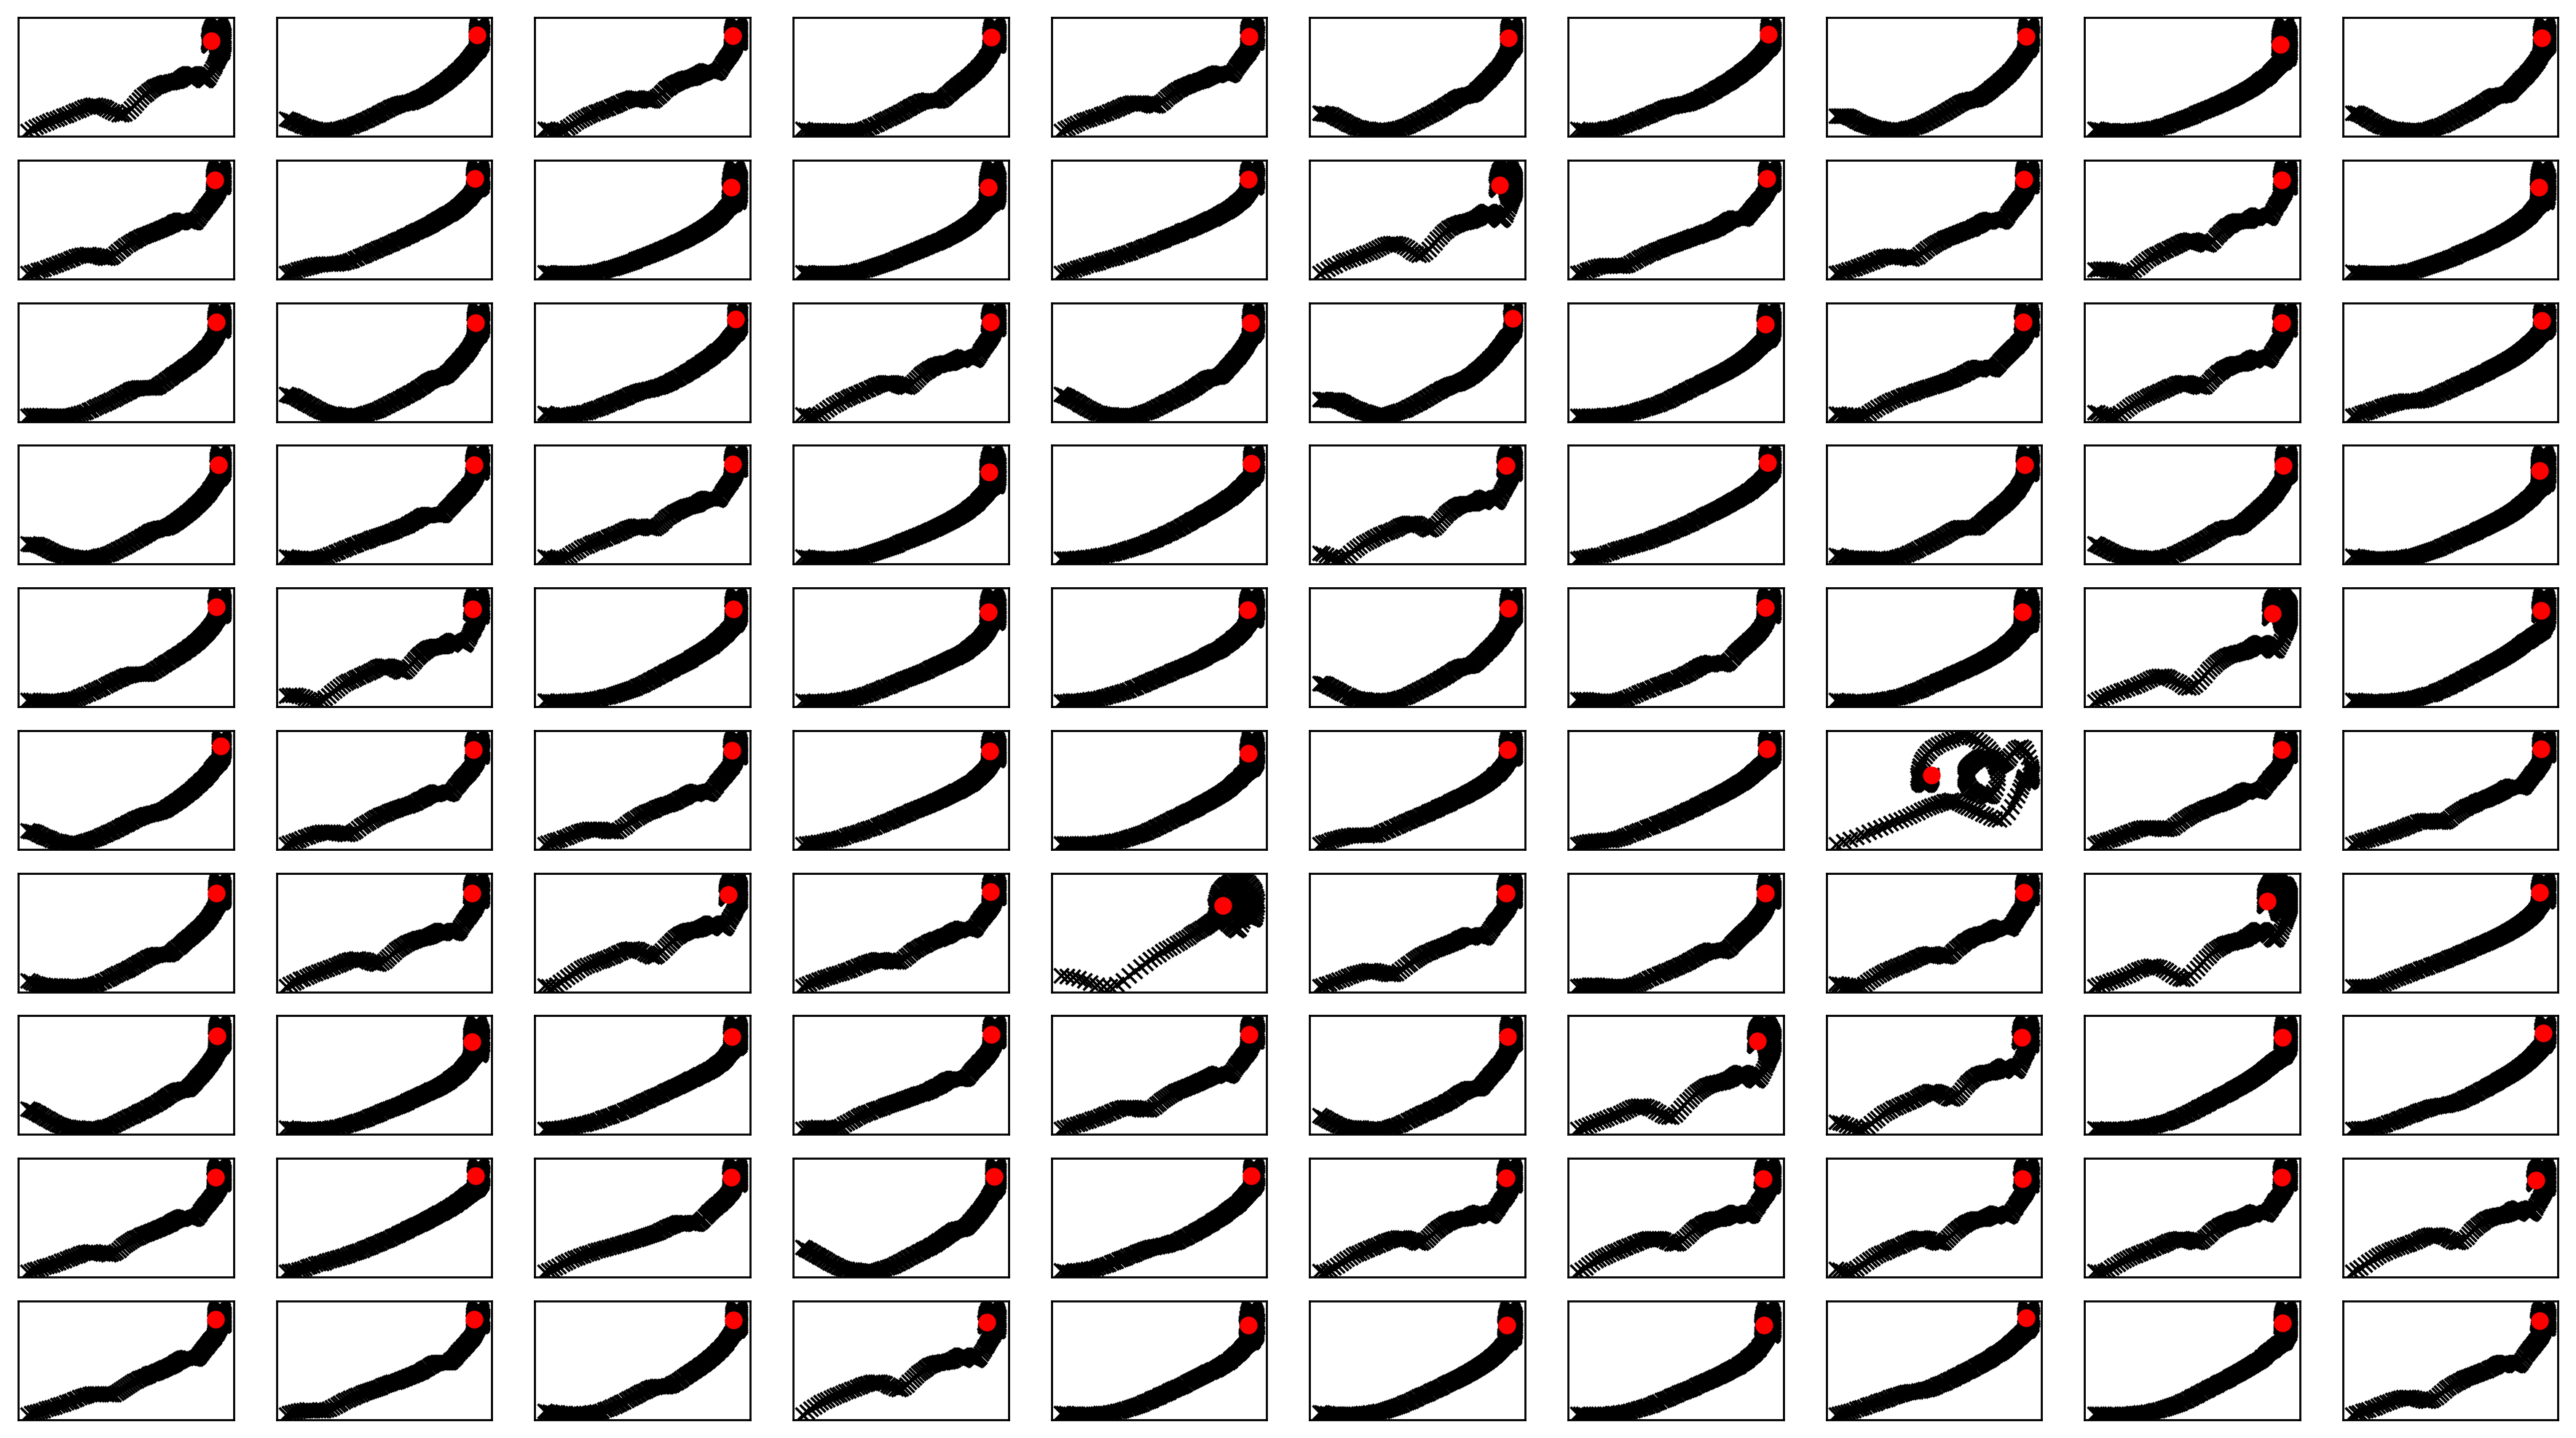

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

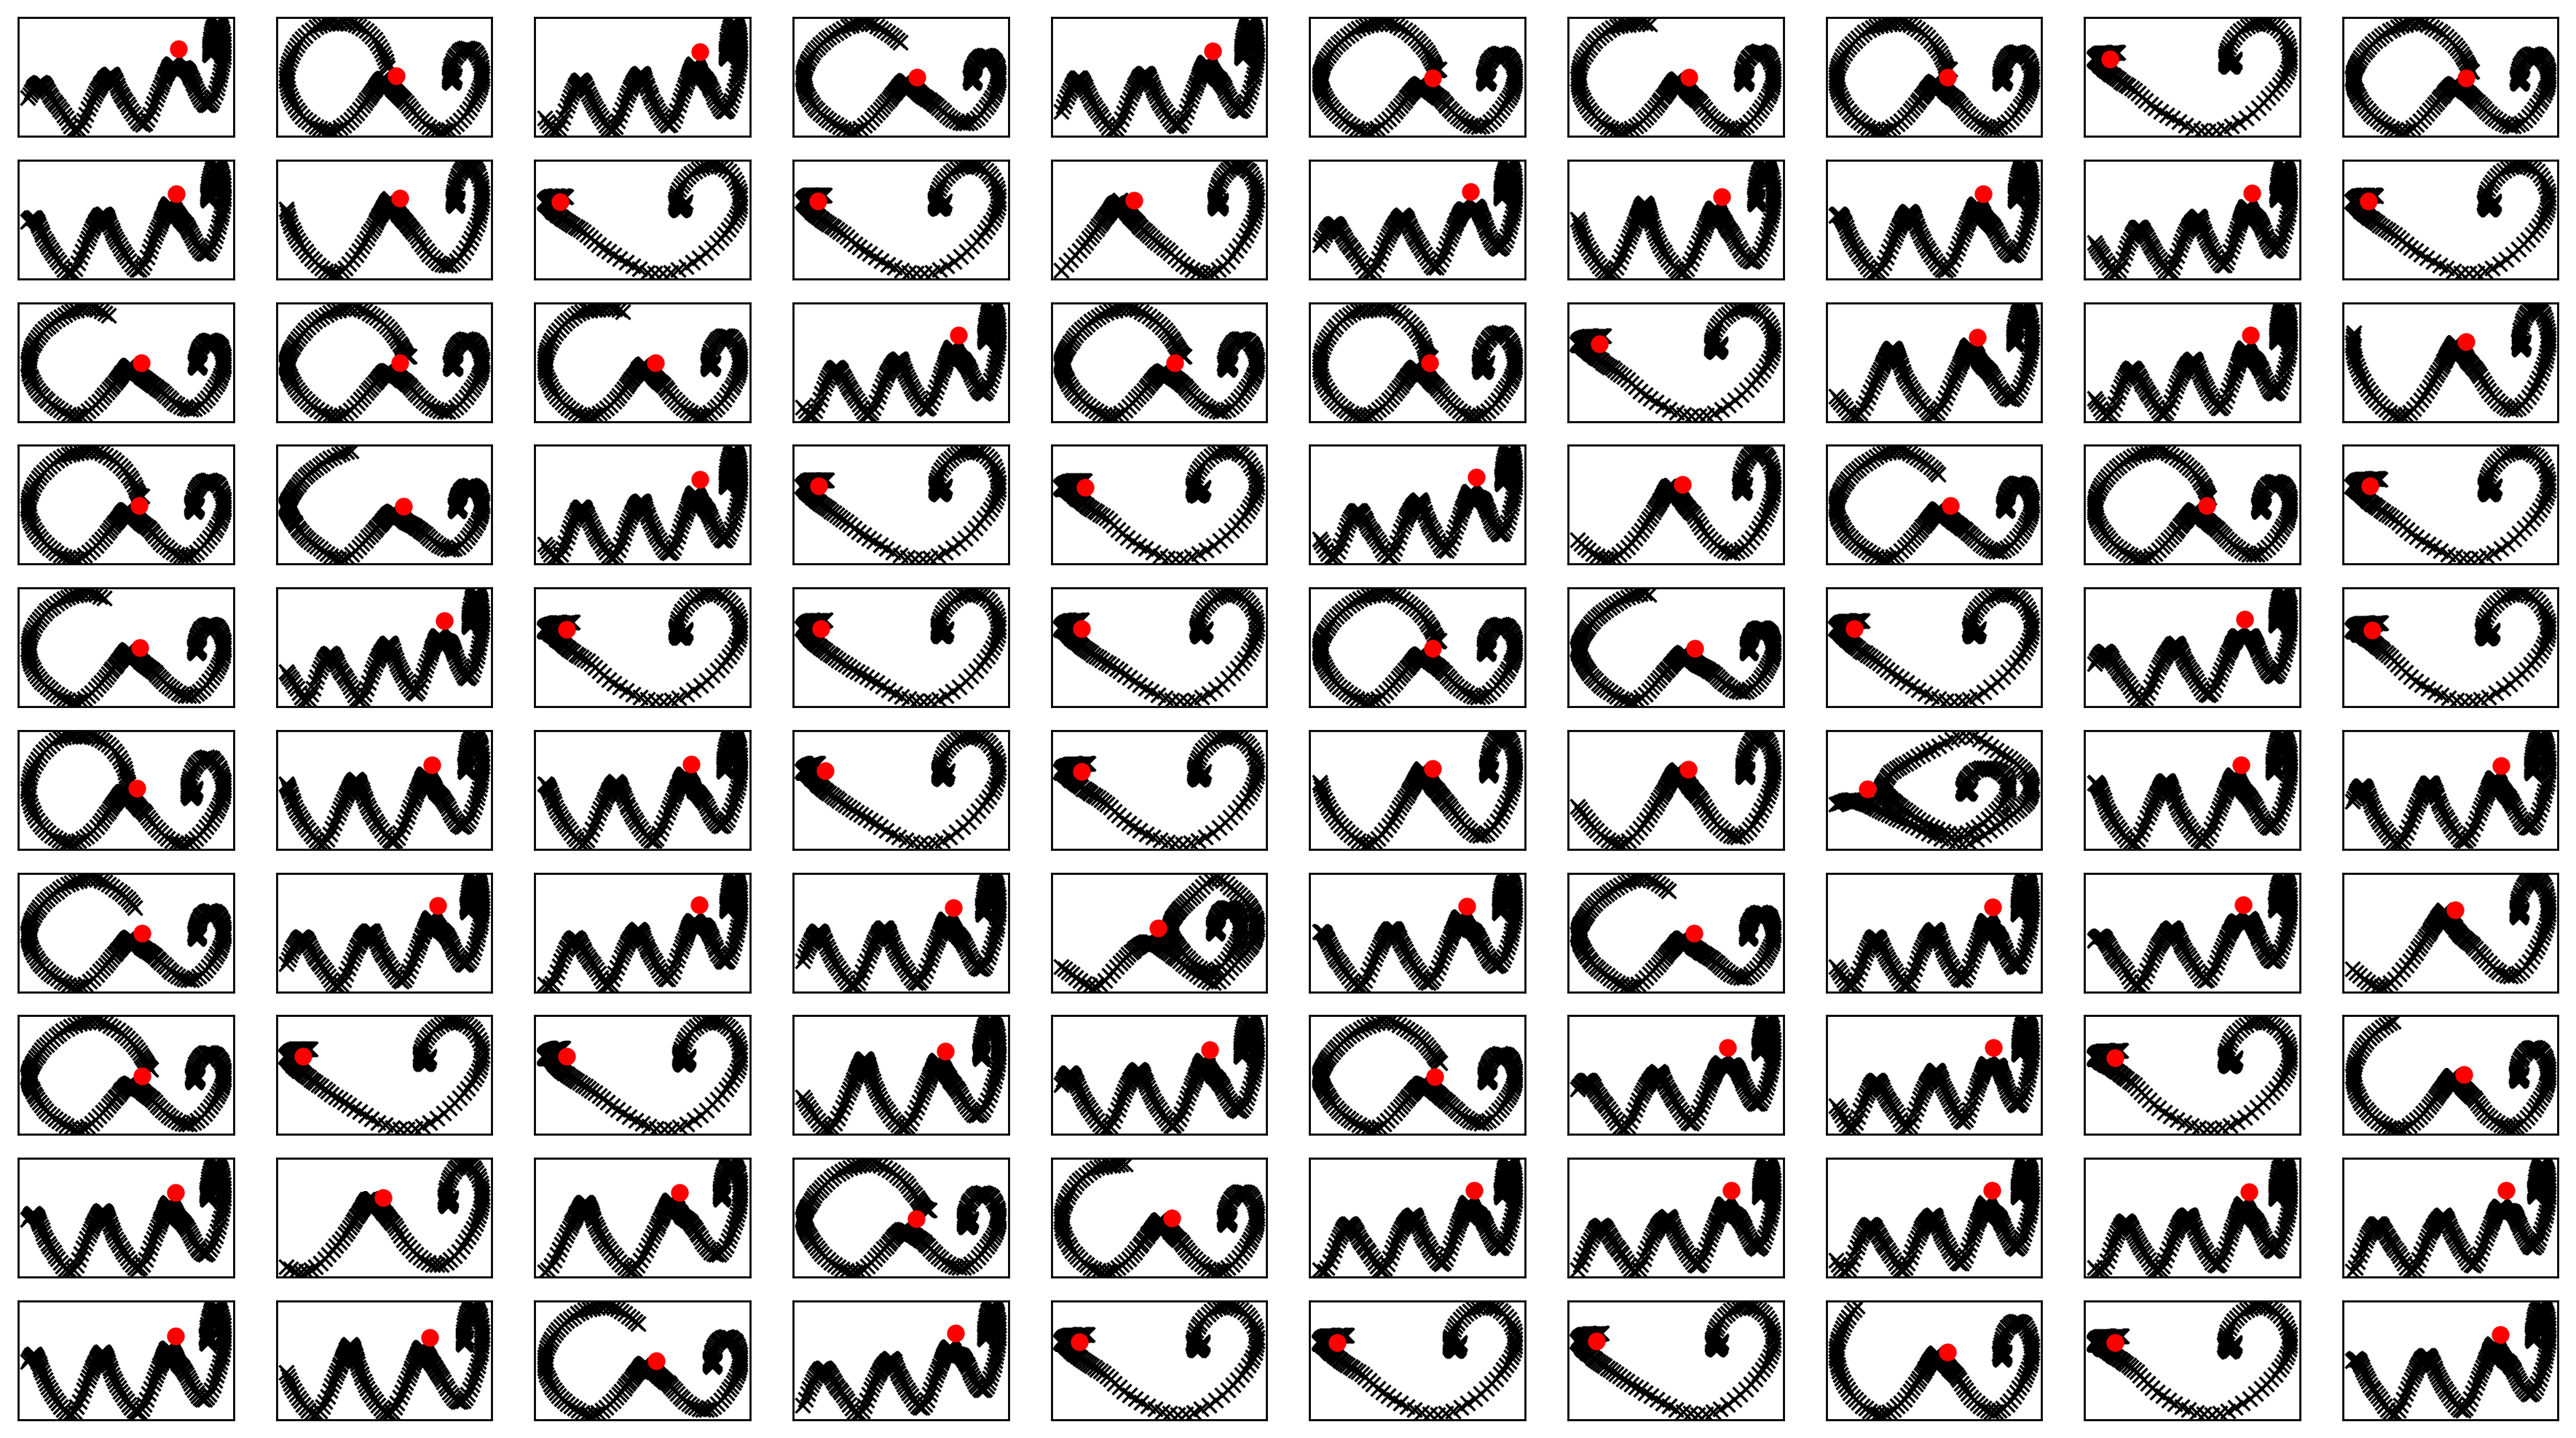

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-04 00:07:43.051486


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.39813  validloss 1.45832±0.00000  bestvalidloss 1.45832  last_update 0
train: iter 1  trainloss 1.33161  validloss 1.33706±0.00000  bestvalidloss 1.33706  last_update 0
train: iter 2  trainloss 1.28345  validloss 1.28531±0.00000  bestvalidloss 1.28531  last_update 0
train: iter 3  trainloss 1.24316  validloss 1.25271±0.00000  bestvalidloss 1.25271  last_update 0
train: iter 4  trainloss 1.20187  validloss 1.21050±0.00000  bestvalidloss 1.21050  last_update 0
train: iter 5  trainloss 1.15631  validloss 1.17635±0.00000  bestvalidloss 1.17635  last_update 0
train: iter 6  trainloss 1.09962  validloss 1.11973±0.00000  bestvalidloss 1.11973  last_update 0
train: iter 7  trainloss 1.02993  validloss 1.05327±0.00000  bestvalidloss 1.05327  last_update 0
train: iter 8  trainloss 0.97907  validloss 1.00947±0.00000  bestvalidloss 1.00947  last_update 0
train: iter 9  trainloss 0.93670  validloss 0.95080±0.00000  bestvalidloss 0.95080  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.66793  validloss 0.74186±0.00000  bestvalidloss 0.71419  last_update 9
train: iter 84  trainloss 0.66962  validloss 0.72094±0.00000  bestvalidloss 0.71419  last_update 10
train: iter 85  trainloss 0.66889  validloss 0.73017±0.00000  bestvalidloss 0.71419  last_update 11
train: iter 86  trainloss 0.67856  validloss 0.73195±0.00000  bestvalidloss 0.71419  last_update 12
train: iter 87  trainloss 0.67863  validloss 0.74212±0.00000  bestvalidloss 0.71419  last_update 13
train: iter 88  trainloss 0.68166  validloss 0.71988±0.00000  bestvalidloss 0.71419  last_update 14
train: iter 89  trainloss 0.67654  validloss 0.72097±0.00000  bestvalidloss 0.71419  last_update 15
train: iter 90  trainloss 0.67148  validloss 0.73147±0.00000  bestvalidloss 0.71419  last_update 16
train: iter 91  trainloss 0.66295  validloss 0.71923±0.00000  bestvalidloss 0.71419  last_update 17
train: iter 92  trainloss 0.66689  validloss 0.72153±0.00000  bestvalidloss 0.71419  last_update 18
t

train: iter 165  trainloss 0.60837  validloss 0.68723±0.00000  bestvalidloss 0.68415  last_update 8
train: iter 166  trainloss 0.61240  validloss 0.71047±0.00000  bestvalidloss 0.68415  last_update 9
train: iter 167  trainloss 0.60111  validloss 0.71132±0.00000  bestvalidloss 0.68415  last_update 10
train: iter 168  trainloss 0.60976  validloss 0.71360±0.00000  bestvalidloss 0.68415  last_update 11
train: iter 169  trainloss 0.60510  validloss 0.69390±0.00000  bestvalidloss 0.68415  last_update 12
train: iter 170  trainloss 0.60736  validloss 0.68793±0.00000  bestvalidloss 0.68415  last_update 13
train: iter 171  trainloss 0.61775  validloss 0.72247±0.00000  bestvalidloss 0.68415  last_update 14
train: iter 172  trainloss 0.60579  validloss 0.69127±0.00000  bestvalidloss 0.68415  last_update 15
train: iter 173  trainloss 0.60283  validloss 0.72340±0.00000  bestvalidloss 0.68415  last_update 16
train: iter 174  trainloss 0.60866  validloss 0.70371±0.00000  bestvalidloss 0.68415  last_up

train: iter 248  trainloss 0.56917  validloss 0.66346±0.00000  bestvalidloss 0.65266  last_update 3
train: iter 249  trainloss 0.55559  validloss 0.66318±0.00000  bestvalidloss 0.65266  last_update 4
train: iter 250  trainloss 0.56765  validloss 0.66863±0.00000  bestvalidloss 0.65266  last_update 5
train: iter 251  trainloss 0.56514  validloss 0.68766±0.00000  bestvalidloss 0.65266  last_update 6
train: iter 252  trainloss 0.56714  validloss 0.66587±0.00000  bestvalidloss 0.65266  last_update 7
train: iter 253  trainloss 0.56536  validloss 0.65752±0.00000  bestvalidloss 0.65266  last_update 8
train: iter 254  trainloss 0.55729  validloss 0.66853±0.00000  bestvalidloss 0.65266  last_update 9
train: iter 255  trainloss 0.56677  validloss 0.66004±0.00000  bestvalidloss 0.65266  last_update 10
train: iter 256  trainloss 0.58164  validloss 0.64598±0.00000  bestvalidloss 0.64598  last_update 0
train: iter 257  trainloss 0.56483  validloss 0.65401±0.00000  bestvalidloss 0.64598  last_update 1

train: iter 330  trainloss 0.53882  validloss 0.65111±0.00000  bestvalidloss 0.62169  last_update 27
train: iter 331  trainloss 0.53581  validloss 0.64645±0.00000  bestvalidloss 0.62169  last_update 28
train: iter 332  trainloss 0.53646  validloss 0.63924±0.00000  bestvalidloss 0.62169  last_update 29
train: iter 333  trainloss 0.52945  validloss 0.64527±0.00000  bestvalidloss 0.62169  last_update 30
train: iter 334  trainloss 0.53143  validloss 0.65113±0.00000  bestvalidloss 0.62169  last_update 31
train: iter 335  trainloss 0.53933  validloss 0.62807±0.00000  bestvalidloss 0.62169  last_update 32
train: iter 336  trainloss 0.53668  validloss 0.66234±0.00000  bestvalidloss 0.62169  last_update 33
train: iter 337  trainloss 0.53183  validloss 0.63479±0.00000  bestvalidloss 0.62169  last_update 34
train: iter 338  trainloss 0.52975  validloss 0.65693±0.00000  bestvalidloss 0.62169  last_update 35
train: iter 339  trainloss 0.53396  validloss 0.62565±0.00000  bestvalidloss 0.62169  last_

train: iter 412  trainloss 0.50863  validloss 0.63586±0.00000  bestvalidloss 0.60925  last_update 33
train: iter 413  trainloss 0.51135  validloss 0.64027±0.00000  bestvalidloss 0.60925  last_update 34
train: iter 414  trainloss 0.50894  validloss 0.63608±0.00000  bestvalidloss 0.60925  last_update 35
train: iter 415  trainloss 0.51068  validloss 0.61506±0.00000  bestvalidloss 0.60925  last_update 36
train: iter 416  trainloss 0.51232  validloss 0.62665±0.00000  bestvalidloss 0.60925  last_update 37
train: iter 417  trainloss 0.51132  validloss 0.64588±0.00000  bestvalidloss 0.60925  last_update 38
train: iter 418  trainloss 0.50815  validloss 0.65053±0.00000  bestvalidloss 0.60925  last_update 39
train: iter 419  trainloss 0.51341  validloss 0.61799±0.00000  bestvalidloss 0.60925  last_update 40
train: iter 420  trainloss 0.51084  validloss 0.61672±0.00000  bestvalidloss 0.60925  last_update 41
train: iter 421  trainloss 0.51360  validloss 0.63120±0.00000  bestvalidloss 0.60925  last_

train: iter 495  trainloss 0.49343  validloss 0.60003±0.00000  bestvalidloss 0.60003  last_update 0
train: iter 496  trainloss 0.49321  validloss 0.60425±0.00000  bestvalidloss 0.60003  last_update 1
train: iter 497  trainloss 0.49312  validloss 0.60759±0.00000  bestvalidloss 0.60003  last_update 2
train: iter 498  trainloss 0.49655  validloss 0.61025±0.00000  bestvalidloss 0.60003  last_update 3
train: iter 499  trainloss 0.48984  validloss 0.62640±0.00000  bestvalidloss 0.60003  last_update 4
train: iter 500  trainloss 0.49478  validloss 0.60636±0.00000  bestvalidloss 0.60003  last_update 5
train: iter 501  trainloss 0.48768  validloss 0.61636±0.00000  bestvalidloss 0.60003  last_update 6
train: iter 502  trainloss 0.49156  validloss 0.60383±0.00000  bestvalidloss 0.60003  last_update 7
train: iter 503  trainloss 0.49169  validloss 0.64196±0.00000  bestvalidloss 0.60003  last_update 8
train: iter 504  trainloss 0.49489  validloss 0.62783±0.00000  bestvalidloss 0.60003  last_update 9


train: iter 577  trainloss 0.48067  validloss 0.62105±0.00000  bestvalidloss 0.59383  last_update 58
train: iter 578  trainloss 0.47168  validloss 0.59704±0.00000  bestvalidloss 0.59383  last_update 59
train: iter 579  trainloss 0.47017  validloss 0.60934±0.00000  bestvalidloss 0.59383  last_update 60
train: iter 580  trainloss 0.48278  validloss 0.65163±0.00000  bestvalidloss 0.59383  last_update 61
train: iter 581  trainloss 0.47840  validloss 0.62395±0.00000  bestvalidloss 0.59383  last_update 62
train: iter 582  trainloss 0.47819  validloss 0.61867±0.00000  bestvalidloss 0.59383  last_update 63
train: iter 583  trainloss 0.47448  validloss 0.60784±0.00000  bestvalidloss 0.59383  last_update 64
train: iter 584  trainloss 0.47211  validloss 0.60718±0.00000  bestvalidloss 0.59383  last_update 65
train: iter 585  trainloss 0.47248  validloss 0.61493±0.00000  bestvalidloss 0.59383  last_update 66
train: iter 586  trainloss 0.47061  validloss 0.60857±0.00000  bestvalidloss 0.59383  last_

([1.3981340065598489,
  1.3316088244318962,
  1.283449449390173,
  1.2431577824056148,
  1.2018652498722076,
  1.1563106298446655,
  1.0996160551905632,
  1.0299278892576695,
  0.979067225009203,
  0.9366964094340802,
  0.9040069848299026,
  0.8829387295991182,
  0.8551908455789089,
  0.8434552133083344,
  0.8264143992215395,
  0.807079927623272,
  0.814277483895421,
  0.8000749826431275,
  0.7899476766586304,
  0.7789760738611221,
  0.7709882471710443,
  0.7657778851687909,
  0.7582011971622705,
  0.7590236894786357,
  0.7595386948436499,
  0.7472612366080285,
  0.7479131948202848,
  0.7459538847208023,
  0.7405860755592585,
  0.7382183045148849,
  0.73690563775599,
  0.7231001663953066,
  0.7356250546872616,
  0.7289195422083139,
  0.7177543856203557,
  0.7232068214565516,
  0.7264723226428031,
  0.7151062689721585,
  0.7210193362087012,
  0.7195712395012379,
  0.711567860841751,
  0.7183927359059453,
  0.7171849936246872,
  0.7181998025625944,
  0.7064737264066935,
  0.7088857479393

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.859733622437715
valid_loss:  -8.128584367728234
weight_alpha 1.0 h_min_tilde -12.319111 ell_tilde -4.7135037714958194 kappa_tilde 0.00036260438927908346
train_loss:  -6.057823124313354
valid_loss:  -5.59451164855957
weight_alpha 0.1 h_min_tilde -12.319111 ell_tilde -5.965160829162597 kappa_tilde 0.0003967145253733945


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1172.34225  validloss -1117.17872±0.00000  bestvalidloss -1117.17872  last_update 0
train: iter 1  trainloss -1186.80063  validloss -1085.61625±0.00000  bestvalidloss -1117.17872  last_update 1
train: iter 2  trainloss -1195.71845  validloss -1086.46819±0.00000  bestvalidloss -1117.17872  last_update 2
train: iter 3  trainloss -1191.85833  validloss -1101.74969±0.00000  bestvalidloss -1117.17872  last_update 3
train: iter 4  trainloss -1130.38742  validloss -1065.73876±0.00000  bestvalidloss -1117.17872  last_update 4
train: iter 5  trainloss -1169.11192  validloss -1006.20730±0.00000  bestvalidloss -1117.17872  last_update 5
train: iter 6  trainloss -1176.09084  validloss -1038.40234±0.00000  bestvalidloss -1117.17872  last_update 6
train: iter 7  trainloss -1199.72053  validloss -1102.91028±0.00000  bestvalidloss -1117.17872  last_update 7
train: iter 8  trainloss -1195.84874  validloss -1096.11496±0.00000  bestva

train: iter 74  trainloss -1197.46188  validloss -1094.65181±0.00000  bestvalidloss -1120.10593  last_update 26
train: iter 75  trainloss -1201.20261  validloss -1094.14035±0.00000  bestvalidloss -1120.10593  last_update 27
train: iter 76  trainloss -1177.95749  validloss -1083.68408±0.00000  bestvalidloss -1120.10593  last_update 28
train: iter 77  trainloss -1196.20749  validloss -1071.81399±0.00000  bestvalidloss -1120.10593  last_update 29
train: iter 78  trainloss -1192.00499  validloss -1094.37961±0.00000  bestvalidloss -1120.10593  last_update 30
train: iter 79  trainloss -1181.60475  validloss -1077.13102±0.00000  bestvalidloss -1120.10593  last_update 31
train: iter 80  trainloss -1197.86083  validloss -1105.23865±0.00000  bestvalidloss -1120.10593  last_update 32
train: iter 81  trainloss -1192.51032  validloss -1098.84787±0.00000  bestvalidloss -1120.10593  last_update 33
train: iter 82  trainloss -1119.46914  validloss -1063.47701±0.00000  bestvalidloss -1120.10593  last_up

train: iter 147  trainloss -1178.01539  validloss -1088.74981±0.00000  bestvalidloss -1120.10593  last_update 99
train: iter 148  trainloss -1200.50209  validloss -1086.85026±0.00000  bestvalidloss -1120.10593  last_update 100
train: fin
penalty_target_min tensor(-12.3235) penalty_target_max tensor(5.2567)


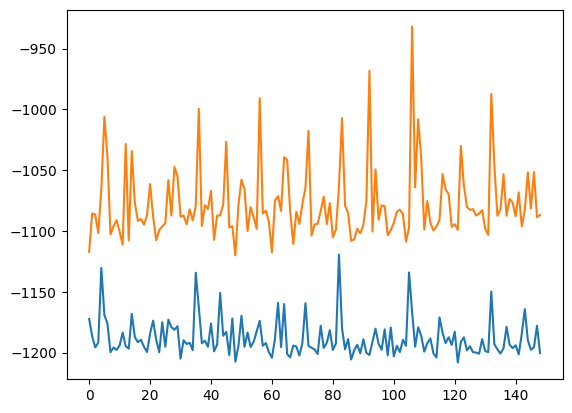

alpha 0.1 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-04 00:37:04.732759


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58810  validloss 0.81690±0.00000  bestvalidloss 0.81690  last_update 0
train: iter 1  trainloss 0.54930  validloss 0.66908±0.00000  bestvalidloss 0.66908  last_update 0
train: iter 2  trainloss 0.55538  validloss 0.66357±0.00000  bestvalidloss 0.66357  last_update 0
train: iter 3  trainloss 0.54469  validloss 0.64974±0.00000  bestvalidloss 0.64974  last_update 0
train: iter 4  trainloss 0.54090  validloss 0.66071±0.00000  bestvalidloss 0.64974  last_update 1
train: iter 5  trainloss 0.53972  validloss 0.64946±0.00000  bestvalidloss 0.64946  last_update 0
train: iter 6  trainloss 0.53531  validloss 0.65215±0.00000  bestvalidloss 0.64946  last_update 1
train: iter 7  trainloss 0.54340  validloss 0.66975±0.00000  bestvalidloss 0.64946  last_update 2
train: iter 8  trainloss 0.53728  validloss 0.65373±0.00000  bestvalidloss 0.64946  last_update 3
train: iter 9  trainloss 0.53468  validloss 0.69684±0.00000  bestvalidloss 0.64946  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.51106  validloss 0.62131±0.00000  bestvalidloss 0.61728  last_update 10
train: iter 84  trainloss 0.49929  validloss 0.61767±0.00000  bestvalidloss 0.61728  last_update 11
train: iter 85  trainloss 0.50316  validloss 0.62428±0.00000  bestvalidloss 0.61728  last_update 12
train: iter 86  trainloss 0.50022  validloss 0.63704±0.00000  bestvalidloss 0.61728  last_update 13
train: iter 87  trainloss 0.50985  validloss 0.61789±0.00000  bestvalidloss 0.61728  last_update 14
train: iter 88  trainloss 0.50521  validloss 0.62576±0.00000  bestvalidloss 0.61728  last_update 15
train: iter 89  trainloss 0.49901  validloss 0.61753±0.00000  bestvalidloss 0.61728  last_update 16
train: iter 90  trainloss 0.49892  validloss 0.62550±0.00000  bestvalidloss 0.61728  last_update 17
train: iter 91  trainloss 0.49504  validloss 0.61935±0.00000  bestvalidloss 0.61728  last_update 18
train: iter 92  trainloss 0.50000  validloss 0.62207±0.00000  bestvalidloss 0.61728  last_update 19


train: iter 165  trainloss 0.48157  validloss 0.60876±0.00000  bestvalidloss 0.60801  last_update 8
train: iter 166  trainloss 0.48303  validloss 0.60520±0.00000  bestvalidloss 0.60520  last_update 0
train: iter 167  trainloss 0.48375  validloss 0.60634±0.00000  bestvalidloss 0.60520  last_update 1
train: iter 168  trainloss 0.48980  validloss 0.62130±0.00000  bestvalidloss 0.60520  last_update 2
train: iter 169  trainloss 0.48191  validloss 0.61153±0.00000  bestvalidloss 0.60520  last_update 3
train: iter 170  trainloss 0.48561  validloss 0.61906±0.00000  bestvalidloss 0.60520  last_update 4
train: iter 171  trainloss 0.49225  validloss 0.61669±0.00000  bestvalidloss 0.60520  last_update 5
train: iter 172  trainloss 0.48616  validloss 0.65144±0.00000  bestvalidloss 0.60520  last_update 6
train: iter 173  trainloss 0.48128  validloss 0.61884±0.00000  bestvalidloss 0.60520  last_update 7
train: iter 174  trainloss 0.47928  validloss 0.60826±0.00000  bestvalidloss 0.60520  last_update 8


train: iter 247  trainloss 0.46915  validloss 0.60283±0.00000  bestvalidloss 0.60283  last_update 0
train: iter 248  trainloss 0.46691  validloss 0.61067±0.00000  bestvalidloss 0.60283  last_update 1
train: iter 249  trainloss 0.47188  validloss 0.60116±0.00000  bestvalidloss 0.60116  last_update 0
train: iter 250  trainloss 0.47114  validloss 0.60827±0.00000  bestvalidloss 0.60116  last_update 1
train: iter 251  trainloss 0.46853  validloss 0.60869±0.00000  bestvalidloss 0.60116  last_update 2
train: iter 252  trainloss 0.47386  validloss 0.59844±0.00000  bestvalidloss 0.59844  last_update 0
train: iter 253  trainloss 0.47411  validloss 0.60702±0.00000  bestvalidloss 0.59844  last_update 1
train: iter 254  trainloss 0.47438  validloss 0.61226±0.00000  bestvalidloss 0.59844  last_update 2
train: iter 255  trainloss 0.48103  validloss 0.60709±0.00000  bestvalidloss 0.59844  last_update 3
train: iter 256  trainloss 0.47032  validloss 0.61082±0.00000  bestvalidloss 0.59844  last_update 4


train: iter 330  trainloss 0.46136  validloss 0.59879±0.00000  bestvalidloss 0.58870  last_update 6
train: iter 331  trainloss 0.46395  validloss 0.59231±0.00000  bestvalidloss 0.58870  last_update 7
train: iter 332  trainloss 0.47278  validloss 0.60512±0.00000  bestvalidloss 0.58870  last_update 8
train: iter 333  trainloss 0.45694  validloss 0.59720±0.00000  bestvalidloss 0.58870  last_update 9
train: iter 334  trainloss 0.45668  validloss 0.59121±0.00000  bestvalidloss 0.58870  last_update 10
train: iter 335  trainloss 0.46082  validloss 0.59424±0.00000  bestvalidloss 0.58870  last_update 11
train: iter 336  trainloss 0.45803  validloss 0.59328±0.00000  bestvalidloss 0.58870  last_update 12
train: iter 337  trainloss 0.46667  validloss 0.59536±0.00000  bestvalidloss 0.58870  last_update 13
train: iter 338  trainloss 0.46394  validloss 0.60675±0.00000  bestvalidloss 0.58870  last_update 14
train: iter 339  trainloss 0.46639  validloss 0.59341±0.00000  bestvalidloss 0.58870  last_upda

train: iter 412  trainloss 0.45328  validloss 0.59234±0.00000  bestvalidloss 0.58352  last_update 31
train: iter 413  trainloss 0.45633  validloss 0.58961±0.00000  bestvalidloss 0.58352  last_update 32
train: iter 414  trainloss 0.45187  validloss 0.58605±0.00000  bestvalidloss 0.58352  last_update 33
train: iter 415  trainloss 0.45213  validloss 0.58648±0.00000  bestvalidloss 0.58352  last_update 34
train: iter 416  trainloss 0.45198  validloss 0.58812±0.00000  bestvalidloss 0.58352  last_update 35
train: iter 417  trainloss 0.45431  validloss 0.60057±0.00000  bestvalidloss 0.58352  last_update 36
train: iter 418  trainloss 0.45218  validloss 0.58225±0.00000  bestvalidloss 0.58225  last_update 0
train: iter 419  trainloss 0.45471  validloss 0.59811±0.00000  bestvalidloss 0.58225  last_update 1
train: iter 420  trainloss 0.45229  validloss 0.59119±0.00000  bestvalidloss 0.58225  last_update 2
train: iter 421  trainloss 0.45641  validloss 0.59930±0.00000  bestvalidloss 0.58225  last_upd

train: iter 494  trainloss 0.45641  validloss 0.58589±0.00000  bestvalidloss 0.57448  last_update 3
train: iter 495  trainloss 0.44063  validloss 0.58809±0.00000  bestvalidloss 0.57448  last_update 4
train: iter 496  trainloss 0.44735  validloss 0.58321±0.00000  bestvalidloss 0.57448  last_update 5
train: iter 497  trainloss 0.44694  validloss 0.58248±0.00000  bestvalidloss 0.57448  last_update 6
train: iter 498  trainloss 0.45370  validloss 0.59149±0.00000  bestvalidloss 0.57448  last_update 7
train: iter 499  trainloss 0.44574  validloss 0.57945±0.00000  bestvalidloss 0.57448  last_update 8
train: iter 500  trainloss 0.44136  validloss 0.57969±0.00000  bestvalidloss 0.57448  last_update 9
train: iter 501  trainloss 0.44449  validloss 0.57546±0.00000  bestvalidloss 0.57448  last_update 10
train: iter 502  trainloss 0.45523  validloss 0.58202±0.00000  bestvalidloss 0.57448  last_update 11
train: iter 503  trainloss 0.44963  validloss 0.57446±0.00000  bestvalidloss 0.57446  last_update 

train: iter 576  trainloss 0.44039  validloss 0.57292±0.00000  bestvalidloss 0.56888  last_update 19
train: iter 577  trainloss 0.43591  validloss 0.58244±0.00000  bestvalidloss 0.56888  last_update 20
train: iter 578  trainloss 0.44801  validloss 0.60038±0.00000  bestvalidloss 0.56888  last_update 21
train: iter 579  trainloss 0.44360  validloss 0.57370±0.00000  bestvalidloss 0.56888  last_update 22
train: iter 580  trainloss 0.43572  validloss 0.57800±0.00000  bestvalidloss 0.56888  last_update 23
train: iter 581  trainloss 0.43887  validloss 0.57987±0.00000  bestvalidloss 0.56888  last_update 24
train: iter 582  trainloss 0.44233  validloss 0.57433±0.00000  bestvalidloss 0.56888  last_update 25
train: iter 583  trainloss 0.44023  validloss 0.57521±0.00000  bestvalidloss 0.56888  last_update 26
train: iter 584  trainloss 0.43443  validloss 0.56706±0.00000  bestvalidloss 0.56706  last_update 0
train: iter 585  trainloss 0.44244  validloss 0.59569±0.00000  bestvalidloss 0.56706  last_u

train: iter 658  trainloss 0.43074  validloss 0.58613±0.00000  bestvalidloss 0.56622  last_update 13
train: iter 659  trainloss 0.42990  validloss 0.56693±0.00000  bestvalidloss 0.56622  last_update 14
train: iter 660  trainloss 0.42939  validloss 0.56906±0.00000  bestvalidloss 0.56622  last_update 15
train: iter 661  trainloss 0.42883  validloss 0.56963±0.00000  bestvalidloss 0.56622  last_update 16
train: iter 662  trainloss 0.43344  validloss 0.59323±0.00000  bestvalidloss 0.56622  last_update 17
train: iter 663  trainloss 0.43381  validloss 0.56957±0.00000  bestvalidloss 0.56622  last_update 18
train: iter 664  trainloss 0.43476  validloss 0.57476±0.00000  bestvalidloss 0.56622  last_update 19
train: iter 665  trainloss 0.43146  validloss 0.56674±0.00000  bestvalidloss 0.56622  last_update 20
train: iter 666  trainloss 0.43185  validloss 0.56846±0.00000  bestvalidloss 0.56622  last_update 21
train: iter 667  trainloss 0.42781  validloss 0.57568±0.00000  bestvalidloss 0.56622  last_

train: iter 741  trainloss 0.42399  validloss 0.56531±0.00000  bestvalidloss 0.56162  last_update 26
train: iter 742  trainloss 0.43199  validloss 0.56220±0.00000  bestvalidloss 0.56162  last_update 27
train: iter 743  trainloss 0.42977  validloss 0.56213±0.00000  bestvalidloss 0.56162  last_update 28
train: iter 744  trainloss 0.42643  validloss 0.55876±0.00000  bestvalidloss 0.55876  last_update 0
train: iter 745  trainloss 0.42284  validloss 0.56379±0.00000  bestvalidloss 0.55876  last_update 1
train: iter 746  trainloss 0.42432  validloss 0.58514±0.00000  bestvalidloss 0.55876  last_update 2
train: iter 747  trainloss 0.42413  validloss 0.56062±0.00000  bestvalidloss 0.55876  last_update 3
train: iter 748  trainloss 0.42128  validloss 0.57157±0.00000  bestvalidloss 0.55876  last_update 4
train: iter 749  trainloss 0.42973  validloss 0.57034±0.00000  bestvalidloss 0.55876  last_update 5
train: iter 750  trainloss 0.42719  validloss 0.56355±0.00000  bestvalidloss 0.55876  last_update

train: iter 823  trainloss 0.42194  validloss 0.56486±0.00000  bestvalidloss 0.55810  last_update 25
train: iter 824  trainloss 0.41979  validloss 0.56335±0.00000  bestvalidloss 0.55810  last_update 26
train: iter 825  trainloss 0.41828  validloss 0.56632±0.00000  bestvalidloss 0.55810  last_update 27
train: iter 826  trainloss 0.41832  validloss 0.56190±0.00000  bestvalidloss 0.55810  last_update 28
train: iter 827  trainloss 0.42033  validloss 0.57239±0.00000  bestvalidloss 0.55810  last_update 29
train: iter 828  trainloss 0.41676  validloss 0.56204±0.00000  bestvalidloss 0.55810  last_update 30
train: iter 829  trainloss 0.41671  validloss 0.56498±0.00000  bestvalidloss 0.55810  last_update 31
train: iter 830  trainloss 0.41605  validloss 0.56789±0.00000  bestvalidloss 0.55810  last_update 32
train: iter 831  trainloss 0.41609  validloss 0.56691±0.00000  bestvalidloss 0.55810  last_update 33
train: iter 832  trainloss 0.42437  validloss 0.57353±0.00000  bestvalidloss 0.55810  last_

train: iter 905  trainloss 0.41339  validloss 0.56556±0.00000  bestvalidloss 0.55710  last_update 2
train: iter 906  trainloss 0.41231  validloss 0.56775±0.00000  bestvalidloss 0.55710  last_update 3
train: iter 907  trainloss 0.41071  validloss 0.56399±0.00000  bestvalidloss 0.55710  last_update 4
train: iter 908  trainloss 0.41145  validloss 0.59374±0.00000  bestvalidloss 0.55710  last_update 5
train: iter 909  trainloss 0.41055  validloss 0.56152±0.00000  bestvalidloss 0.55710  last_update 6
train: iter 910  trainloss 0.41438  validloss 0.56541±0.00000  bestvalidloss 0.55710  last_update 7
train: iter 911  trainloss 0.41336  validloss 0.59116±0.00000  bestvalidloss 0.55710  last_update 8
train: iter 912  trainloss 0.42268  validloss 0.57710±0.00000  bestvalidloss 0.55710  last_update 9
train: iter 913  trainloss 0.41418  validloss 0.58950±0.00000  bestvalidloss 0.55710  last_update 10
train: iter 914  trainloss 0.41116  validloss 0.56898±0.00000  bestvalidloss 0.55710  last_update 1

train: iter 987  trainloss 0.40905  validloss 0.57420±0.00000  bestvalidloss 0.55479  last_update 51
train: iter 988  trainloss 0.40670  validloss 0.56294±0.00000  bestvalidloss 0.55479  last_update 52
train: iter 989  trainloss 0.40735  validloss 0.57546±0.00000  bestvalidloss 0.55479  last_update 53
train: iter 990  trainloss 0.40545  validloss 0.55692±0.00000  bestvalidloss 0.55479  last_update 54
train: iter 991  trainloss 0.40481  validloss 0.56796±0.00000  bestvalidloss 0.55479  last_update 55
train: iter 992  trainloss 0.40424  validloss 0.56661±0.00000  bestvalidloss 0.55479  last_update 56
train: iter 993  trainloss 0.40509  validloss 0.56283±0.00000  bestvalidloss 0.55479  last_update 57
train: iter 994  trainloss 0.40924  validloss 0.55688±0.00000  bestvalidloss 0.55479  last_update 58
train: iter 995  trainloss 0.40519  validloss 0.57909±0.00000  bestvalidloss 0.55479  last_update 59
train: iter 996  trainloss 0.40474  validloss 0.57112±0.00000  bestvalidloss 0.55479  last_

([0.5880969481542706,
  0.5492962719872594,
  0.555382183380425,
  0.544694808870554,
  0.540899452380836,
  0.5397196423262358,
  0.5353145148605108,
  0.5433957006782293,
  0.5372784147039056,
  0.5346837028861046,
  0.5271795747801662,
  0.543369534984231,
  0.5405029153451324,
  0.5251062661409378,
  0.5256161544471979,
  0.5313796687871217,
  0.5272348059341312,
  0.5243946952745319,
  0.5253842098638415,
  0.5261480612680316,
  0.5299216847866773,
  0.527940989844501,
  0.5248374670743943,
  0.5191693698987365,
  0.5277230218052864,
  0.5313475053757429,
  0.5203099861741066,
  0.5149608774110674,
  0.532725290954113,
  0.5211097747087479,
  0.5190342484042049,
  0.5235394943505526,
  0.5209438743069768,
  0.5193485720083117,
  0.5200075231492519,
  0.5165040558204055,
  0.515422373265028,
  0.5155976332724095,
  0.5185899602249264,
  0.5226052198559046,
  0.5148847533389926,
  0.5117712963372469,
  0.5262530000880361,
  0.516345371492207,
  0.5096275700256229,
  0.52182669155299

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.084714986550809
valid_loss:  -10.120428005886078
weight_alpha 1.0 h_min_tilde -12.323545 ell_tilde -6.891857590417862 kappa_tilde 0.000429074393691581
train_loss:  -6.15906779975891
valid_loss:  -5.360267904663086
weight_alpha 0.1 h_min_tilde -12.323545 ell_tilde -5.999307820739745 kappa_tilde 0.0003976453514577695


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1220.98721  validloss -1067.41605±0.00000  bestvalidloss -1067.41605  last_update 0
train: iter 1  trainloss -1218.83031  validloss -1075.83181±0.00000  bestvalidloss -1075.83181  last_update 0
train: iter 2  trainloss -1221.87233  validloss -1064.39984±0.00000  bestvalidloss -1075.83181  last_update 1
train: iter 3  trainloss -1221.98603  validloss -1078.11044±0.00000  bestvalidloss -1078.11044  last_update 0
train: iter 4  trainloss -1218.03797  validloss -1043.98606±0.00000  bestvalidloss -1078.11044  last_update 1
train: iter 5  trainloss -1221.22882  validloss -1084.25863±0.00000  bestvalidloss -1084.25863  last_update 0
train: iter 6  trainloss -1224.42985  validloss -1033.35293±0.00000  bestvalidloss -1084.25863  last_update 1
train: iter 7  trainloss -1208.03133  validloss -1035.66427±0.00000  bestvalidloss -1084.25863  last_update 2
train: iter 8  trainloss -1224.68324  validloss -1050.85970±0.00000  bestva

train: iter 74  trainloss -1202.95119  validloss -1014.61636±0.00000  bestvalidloss -1098.85709  last_update 41
train: iter 75  trainloss -1214.71110  validloss -1057.61451±0.00000  bestvalidloss -1098.85709  last_update 42
train: iter 76  trainloss -1220.25120  validloss -1080.01217±0.00000  bestvalidloss -1098.85709  last_update 43
train: iter 77  trainloss -1194.70425  validloss -1049.68156±0.00000  bestvalidloss -1098.85709  last_update 44
train: iter 78  trainloss -1217.06145  validloss -1056.46681±0.00000  bestvalidloss -1098.85709  last_update 45
train: iter 79  trainloss -1207.11871  validloss -1063.17287±0.00000  bestvalidloss -1098.85709  last_update 46
train: iter 80  trainloss -1206.78077  validloss -1033.87902±0.00000  bestvalidloss -1098.85709  last_update 47
train: iter 81  trainloss -1210.69186  validloss -1060.02599±0.00000  bestvalidloss -1098.85709  last_update 48
train: iter 82  trainloss -1162.91914  validloss -1003.57827±0.00000  bestvalidloss -1098.85709  last_up

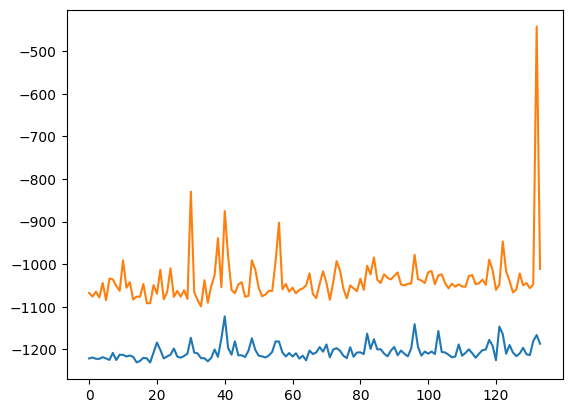

alpha 0.1 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-04 00:58:39.101687


Text(0, 0.5, 'loss')

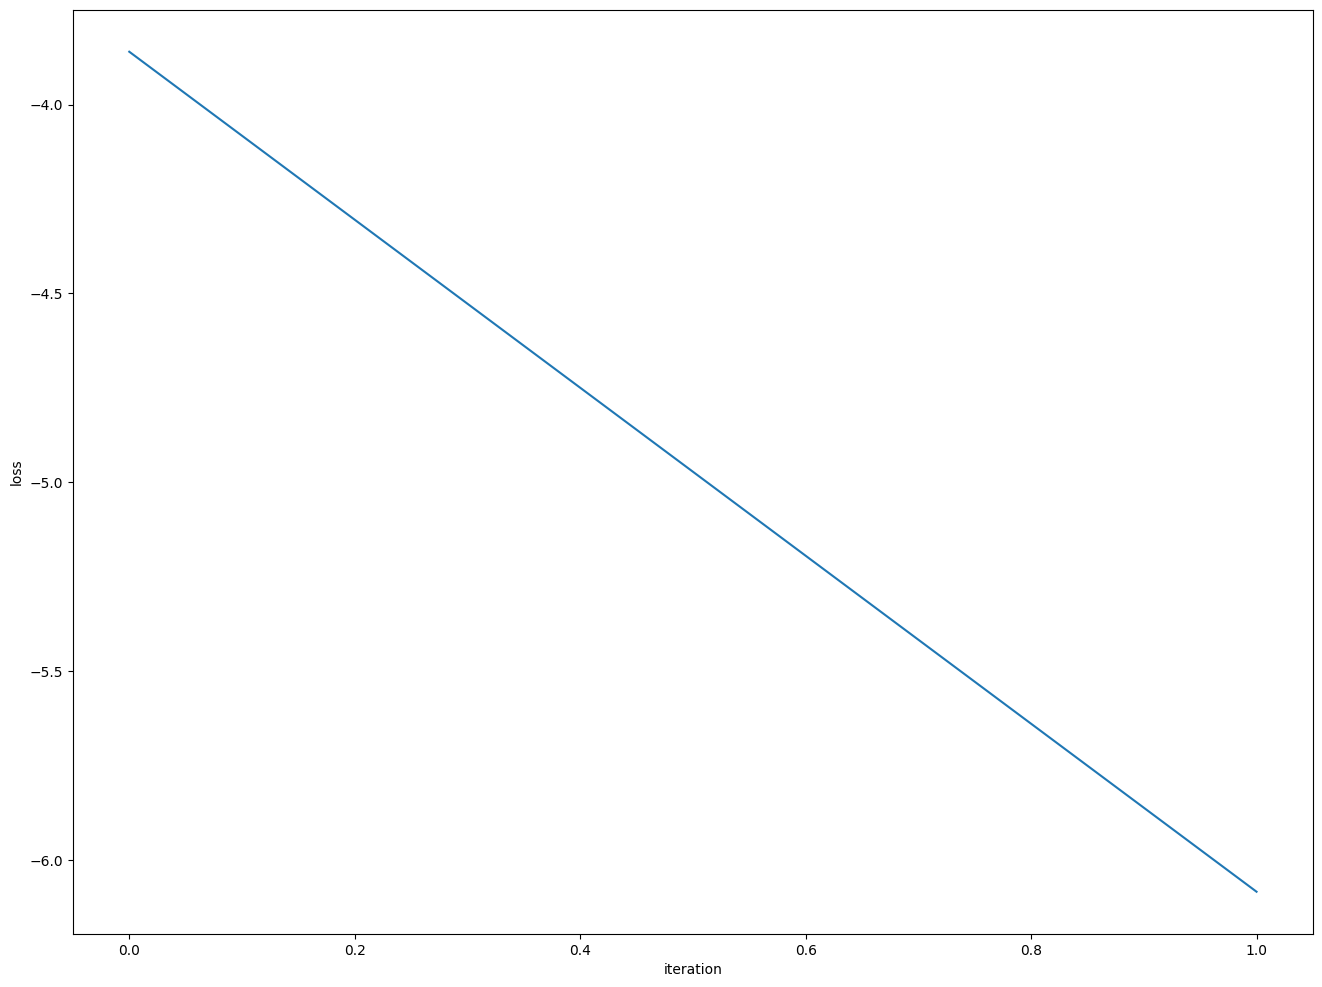

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

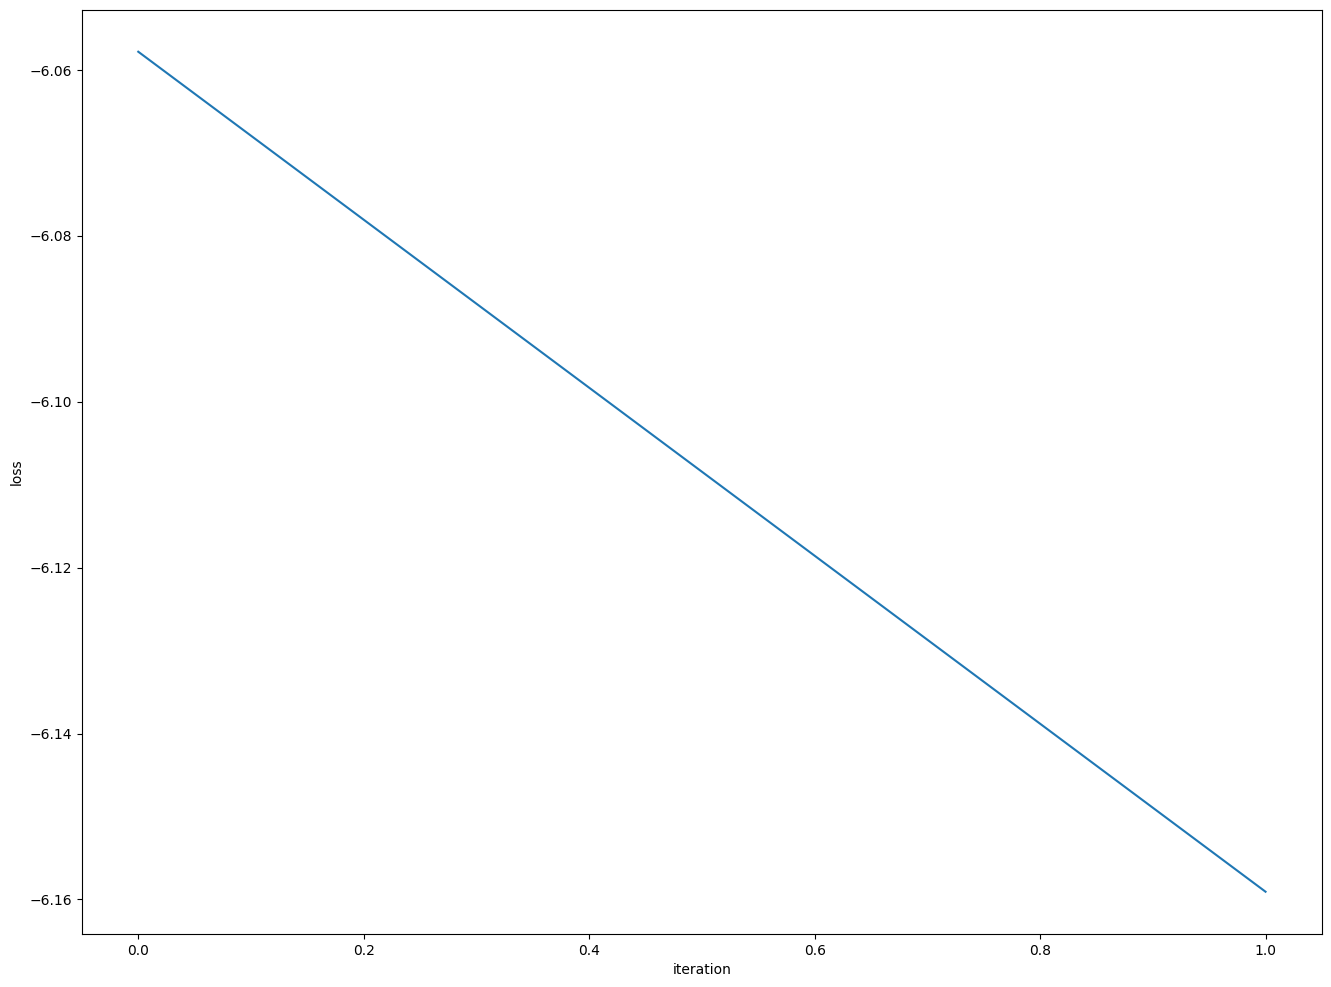

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.53525  validloss 0.78128±0.00000  bestvalidloss 0.78128  last_update 0
train: iter 1  trainloss 0.51393  validloss 0.69039±0.00000  bestvalidloss 0.69039  last_update 0
train: iter 2  trainloss 0.50024  validloss 0.65717±0.00000  bestvalidloss 0.65717  last_update 0
train: iter 3  trainloss 0.50030  validloss 0.65114±0.00000  bestvalidloss 0.65114  last_update 0
train: iter 4  trainloss 0.49059  validloss 0.65136±0.00000  bestvalidloss 0.65114  last_update 1
train: iter 5  trainloss 0.49110  validloss 0.64397±0.00000  bestvalidloss 0.64397  last_update 0
train: iter 6  trainloss 0.48780  validloss 0.64363±0.00000  bestvalidloss 0.64363  last_update 0
train: iter 7  trainloss 0.49148  validloss 0.64774±0.00000  bestvalidloss 0.64363  last_update 1
train: iter 8  trainloss 0.48967  validloss 0.63477±0.00000  bestvalidloss 0.63477  last_update 0
train: iter 9  trainloss 0.48726  validloss 0.63016±0.00000  bestvalidloss 0.63016  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.45253  validloss 0.59854±0.00000  bestvalidloss 0.59521  last_update 1
train: iter 84  trainloss 0.45625  validloss 0.60857±0.00000  bestvalidloss 0.59521  last_update 2
train: iter 85  trainloss 0.44938  validloss 0.59819±0.00000  bestvalidloss 0.59521  last_update 3
train: iter 86  trainloss 0.45419  validloss 0.59558±0.00000  bestvalidloss 0.59521  last_update 4
train: iter 87  trainloss 0.45740  validloss 0.59484±0.00000  bestvalidloss 0.59484  last_update 0
train: iter 88  trainloss 0.46383  validloss 0.59868±0.00000  bestvalidloss 0.59484  last_update 1
train: iter 89  trainloss 0.45199  validloss 0.60190±0.00000  bestvalidloss 0.59484  last_update 2
train: iter 90  trainloss 0.45688  validloss 0.59899±0.00000  bestvalidloss 0.59484  last_update 3
train: iter 91  trainloss 0.45217  validloss 0.60190±0.00000  bestvalidloss 0.59484  last_update 4
train: iter 92  trainloss 0.45072  validloss 0.60648±0.00000  bestvalidloss 0.59484  last_update 5
train: ite

train: iter 165  trainloss 0.44219  validloss 0.57475±0.00000  bestvalidloss 0.57475  last_update 0
train: iter 166  trainloss 0.44783  validloss 0.57862±0.00000  bestvalidloss 0.57475  last_update 1
train: iter 167  trainloss 0.43964  validloss 0.57556±0.00000  bestvalidloss 0.57475  last_update 2
train: iter 168  trainloss 0.44201  validloss 0.57184±0.00000  bestvalidloss 0.57184  last_update 0
train: iter 169  trainloss 0.44106  validloss 0.59463±0.00000  bestvalidloss 0.57184  last_update 1
train: iter 170  trainloss 0.43997  validloss 0.57691±0.00000  bestvalidloss 0.57184  last_update 2
train: iter 171  trainloss 0.43591  validloss 0.59017±0.00000  bestvalidloss 0.57184  last_update 3
train: iter 172  trainloss 0.43998  validloss 0.58534±0.00000  bestvalidloss 0.57184  last_update 4
train: iter 173  trainloss 0.44013  validloss 0.57449±0.00000  bestvalidloss 0.57184  last_update 5
train: iter 174  trainloss 0.43791  validloss 0.57656±0.00000  bestvalidloss 0.57184  last_update 6


train: iter 247  trainloss 0.42846  validloss 0.56069±0.00000  bestvalidloss 0.56014  last_update 15
train: iter 248  trainloss 0.43180  validloss 0.55885±0.00000  bestvalidloss 0.55885  last_update 0
train: iter 249  trainloss 0.42795  validloss 0.56602±0.00000  bestvalidloss 0.55885  last_update 1
train: iter 250  trainloss 0.42537  validloss 0.56906±0.00000  bestvalidloss 0.55885  last_update 2
train: iter 251  trainloss 0.42584  validloss 0.57761±0.00000  bestvalidloss 0.55885  last_update 3
train: iter 252  trainloss 0.42855  validloss 0.57499±0.00000  bestvalidloss 0.55885  last_update 4
train: iter 253  trainloss 0.42590  validloss 0.57304±0.00000  bestvalidloss 0.55885  last_update 5
train: iter 254  trainloss 0.42405  validloss 0.58273±0.00000  bestvalidloss 0.55885  last_update 6
train: iter 255  trainloss 0.42560  validloss 0.56451±0.00000  bestvalidloss 0.55885  last_update 7
train: iter 256  trainloss 0.42742  validloss 0.56402±0.00000  bestvalidloss 0.55885  last_update 8

train: iter 330  trainloss 0.41643  validloss 0.55957±0.00000  bestvalidloss 0.55131  last_update 11
train: iter 331  trainloss 0.42092  validloss 0.58378±0.00000  bestvalidloss 0.55131  last_update 12
train: iter 332  trainloss 0.42069  validloss 0.56638±0.00000  bestvalidloss 0.55131  last_update 13
train: iter 333  trainloss 0.41635  validloss 0.55743±0.00000  bestvalidloss 0.55131  last_update 14
train: iter 334  trainloss 0.41697  validloss 0.55859±0.00000  bestvalidloss 0.55131  last_update 15
train: iter 335  trainloss 0.41483  validloss 0.55696±0.00000  bestvalidloss 0.55131  last_update 16
train: iter 336  trainloss 0.41583  validloss 0.55698±0.00000  bestvalidloss 0.55131  last_update 17
train: iter 337  trainloss 0.41591  validloss 0.56791±0.00000  bestvalidloss 0.55131  last_update 18
train: iter 338  trainloss 0.41507  validloss 0.56760±0.00000  bestvalidloss 0.55131  last_update 19
train: iter 339  trainloss 0.41855  validloss 0.56881±0.00000  bestvalidloss 0.55131  last_

train: iter 412  trainloss 0.41103  validloss 0.55474±0.00000  bestvalidloss 0.54668  last_update 21
train: iter 413  trainloss 0.40855  validloss 0.56711±0.00000  bestvalidloss 0.54668  last_update 22
train: iter 414  trainloss 0.41038  validloss 0.55753±0.00000  bestvalidloss 0.54668  last_update 23
train: iter 415  trainloss 0.40625  validloss 0.55332±0.00000  bestvalidloss 0.54668  last_update 24
train: iter 416  trainloss 0.41043  validloss 0.55495±0.00000  bestvalidloss 0.54668  last_update 25
train: iter 417  trainloss 0.40686  validloss 0.55024±0.00000  bestvalidloss 0.54668  last_update 26
train: iter 418  trainloss 0.40530  validloss 0.54815±0.00000  bestvalidloss 0.54668  last_update 27
train: iter 419  trainloss 0.40832  validloss 0.56281±0.00000  bestvalidloss 0.54668  last_update 28
train: iter 420  trainloss 0.40586  validloss 0.57902±0.00000  bestvalidloss 0.54668  last_update 29
train: iter 421  trainloss 0.40553  validloss 0.54536±0.00000  bestvalidloss 0.54536  last_

train: iter 494  trainloss 0.40277  validloss 0.56559±0.00000  bestvalidloss 0.54296  last_update 54
train: iter 495  trainloss 0.39671  validloss 0.55293±0.00000  bestvalidloss 0.54296  last_update 55
train: iter 496  trainloss 0.39785  validloss 0.54430±0.00000  bestvalidloss 0.54296  last_update 56
train: iter 497  trainloss 0.39709  validloss 0.57245±0.00000  bestvalidloss 0.54296  last_update 57
train: iter 498  trainloss 0.39790  validloss 0.54335±0.00000  bestvalidloss 0.54296  last_update 58
train: iter 499  trainloss 0.39795  validloss 0.55052±0.00000  bestvalidloss 0.54296  last_update 59
train: iter 500  trainloss 0.40019  validloss 0.55562±0.00000  bestvalidloss 0.54296  last_update 60
train: iter 501  trainloss 0.39913  validloss 0.54636±0.00000  bestvalidloss 0.54296  last_update 61
train: iter 502  trainloss 0.40032  validloss 0.56906±0.00000  bestvalidloss 0.54296  last_update 62
train: iter 503  trainloss 0.39530  validloss 0.54506±0.00000  bestvalidloss 0.54296  last_

train: iter 576  trainloss 0.38698  validloss 0.55143±0.00000  bestvalidloss 0.54269  last_update 53
train: iter 577  trainloss 0.39000  validloss 0.55002±0.00000  bestvalidloss 0.54269  last_update 54
train: iter 578  trainloss 0.38933  validloss 0.56377±0.00000  bestvalidloss 0.54269  last_update 55
train: iter 579  trainloss 0.39198  validloss 0.56431±0.00000  bestvalidloss 0.54269  last_update 56
train: iter 580  trainloss 0.39130  validloss 0.55018±0.00000  bestvalidloss 0.54269  last_update 57
train: iter 581  trainloss 0.38982  validloss 0.54749±0.00000  bestvalidloss 0.54269  last_update 58
train: iter 582  trainloss 0.38981  validloss 0.56436±0.00000  bestvalidloss 0.54269  last_update 59
train: iter 583  trainloss 0.39140  validloss 0.55136±0.00000  bestvalidloss 0.54269  last_update 60
train: iter 584  trainloss 0.39537  validloss 0.55353±0.00000  bestvalidloss 0.54269  last_update 61
train: iter 585  trainloss 0.39212  validloss 0.58894±0.00000  bestvalidloss 0.54269  last_

([0.5352461978793144,
  0.5139280708506704,
  0.5002423556521535,
  0.5003020210191608,
  0.4905875366181135,
  0.4910990821197629,
  0.48780125863850116,
  0.49147909674793483,
  0.4896680122241378,
  0.48726075179874895,
  0.4825054336339235,
  0.4823240801692009,
  0.48078990206122396,
  0.47916983142495156,
  0.4782589176669717,
  0.4809125352650881,
  0.47770112063735726,
  0.4734153624624014,
  0.4742528198286891,
  0.4760858388617635,
  0.4800550762563944,
  0.47932593766599896,
  0.4734837317839265,
  0.47036431897431613,
  0.4753442442044616,
  0.4697635630145669,
  0.46900893058627846,
  0.47146647423505783,
  0.46969375368207694,
  0.47169721908867357,
  0.4697481689974666,
  0.47556618638336656,
  0.4696073576807976,
  0.47097641211003066,
  0.46837932635098695,
  0.47752390056848526,
  0.47273335661739113,
  0.4681291228160262,
  0.4681207090616226,
  0.4687297185882926,
  0.467183087579906,
  0.46859313677996395,
  0.47117770127952097,
  0.46797678265720605,
  0.465410921

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.168978448188304
valid_loss:  -7.026868218517303
weight_alpha 1.0 h_min_tilde -12.322123 ell_tilde -5.540556402254104 kappa_tilde 0.00038400333673484124
train_loss:  -5.766316108894348
valid_loss:  -4.966967288208008
weight_alpha 0.1 h_min_tilde -12.322123 ell_tilde -5.60644634475708 kappa_tilde 0.0003858825368213246


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1129.66026  validloss -991.06637±0.00000  bestvalidloss -991.06637  last_update 0
train: iter 1  trainloss -1155.17325  validloss -984.02696±0.00000  bestvalidloss -991.06637  last_update 1
train: iter 2  trainloss -1148.36788  validloss -1013.81816±0.00000  bestvalidloss -1013.81816  last_update 0
train: iter 3  trainloss -1133.69715  validloss -998.64462±0.00000  bestvalidloss -1013.81816  last_update 1
train: iter 4  trainloss -1137.00467  validloss -1003.07005±0.00000  bestvalidloss -1013.81816  last_update 2
train: iter 5  trainloss -1152.12775  validloss -984.87226±0.00000  bestvalidloss -1013.81816  last_update 3
train: iter 6  trainloss -1154.27364  validloss -1002.03265±0.00000  bestvalidloss -1013.81816  last_update 4
train: iter 7  trainloss -1130.94877  validloss -986.68807±0.00000  bestvalidloss -1013.81816  last_update 5
train: iter 8  trainloss -1143.14098  validloss -996.60477±0.00000  bestvalidloss 

train: iter 74  trainloss -1142.20353  validloss -972.44612±0.00000  bestvalidloss -1019.68756  last_update 32
train: iter 75  trainloss -1149.30089  validloss -976.74504±0.00000  bestvalidloss -1019.68756  last_update 33
train: iter 76  trainloss -1151.48198  validloss -965.91226±0.00000  bestvalidloss -1019.68756  last_update 34
train: iter 77  trainloss -1130.84024  validloss -972.79585±0.00000  bestvalidloss -1019.68756  last_update 35
train: iter 78  trainloss -1144.66987  validloss -989.30794±0.00000  bestvalidloss -1019.68756  last_update 36
train: iter 79  trainloss -1137.01069  validloss -968.63060±0.00000  bestvalidloss -1019.68756  last_update 37
train: iter 80  trainloss -1141.77748  validloss -979.37625±0.00000  bestvalidloss -1019.68756  last_update 38
train: iter 81  trainloss -1080.98463  validloss -913.95427±0.00000  bestvalidloss -1019.68756  last_update 39
train: iter 82  trainloss -1129.69949  validloss -951.86623±0.00000  bestvalidloss -1019.68756  last_update 40
t

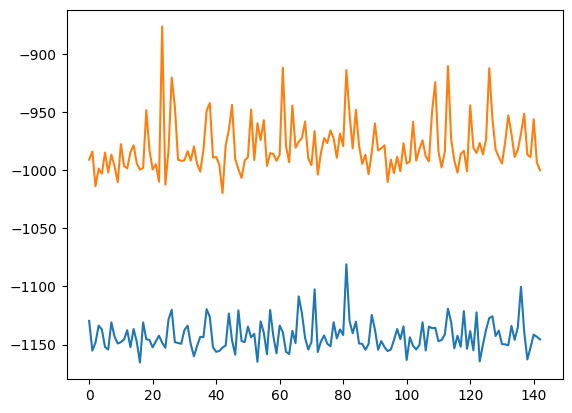

alpha 0.1 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-04 01:17:49.777467


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51911  validloss 0.73143±0.00000  bestvalidloss 0.73143  last_update 0
train: iter 1  trainloss 0.49911  validloss 0.60212±0.00000  bestvalidloss 0.60212  last_update 0
train: iter 2  trainloss 0.49011  validloss 0.61845±0.00000  bestvalidloss 0.60212  last_update 1
train: iter 3  trainloss 0.48751  validloss 0.59021±0.00000  bestvalidloss 0.59021  last_update 0
train: iter 4  trainloss 0.48039  validloss 0.60074±0.00000  bestvalidloss 0.59021  last_update 1
train: iter 5  trainloss 0.48694  validloss 0.60487±0.00000  bestvalidloss 0.59021  last_update 2
train: iter 6  trainloss 0.48166  validloss 0.61218±0.00000  bestvalidloss 0.59021  last_update 3
train: iter 7  trainloss 0.47973  validloss 0.63524±0.00000  bestvalidloss 0.59021  last_update 4
train: iter 8  trainloss 0.47138  validloss 0.62498±0.00000  bestvalidloss 0.59021  last_update 5
train: iter 9  trainloss 0.47628  validloss 0.60115±0.00000  bestvalidloss 0.59021  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.43166  validloss 0.58239±0.00000  bestvalidloss 0.56684  last_update 18
train: iter 84  trainloss 0.43780  validloss 0.60558±0.00000  bestvalidloss 0.56684  last_update 19
train: iter 85  trainloss 0.43415  validloss 0.60876±0.00000  bestvalidloss 0.56684  last_update 20
train: iter 86  trainloss 0.43096  validloss 0.58760±0.00000  bestvalidloss 0.56684  last_update 21
train: iter 87  trainloss 0.43090  validloss 0.59564±0.00000  bestvalidloss 0.56684  last_update 22
train: iter 88  trainloss 0.43344  validloss 0.61340±0.00000  bestvalidloss 0.56684  last_update 23
train: iter 89  trainloss 0.43312  validloss 0.57546±0.00000  bestvalidloss 0.56684  last_update 24
train: iter 90  trainloss 0.43470  validloss 0.58514±0.00000  bestvalidloss 0.56684  last_update 25
train: iter 91  trainloss 0.43276  validloss 0.57238±0.00000  bestvalidloss 0.56684  last_update 26
train: iter 92  trainloss 0.43529  validloss 0.58022±0.00000  bestvalidloss 0.56684  last_update 27


train: iter 165  trainloss 0.41428  validloss 0.59167±0.00000  bestvalidloss 0.56684  last_update 100
train: fin


([0.519113171286881,
  0.49911168180406096,
  0.49010584633797405,
  0.48751449938863517,
  0.4803885599598289,
  0.4869426580145955,
  0.48166258409619334,
  0.4797312071546912,
  0.4713771100156009,
  0.4762805001810193,
  0.47472675470635295,
  0.46878974940627816,
  0.4698405794799328,
  0.47079053726047276,
  0.4692944157868624,
  0.4653882382437587,
  0.4623713202774525,
  0.4609553016722202,
  0.4637157812714577,
  0.4623941768892109,
  0.4641806442290545,
  0.46183494720608,
  0.4576166432350874,
  0.4606356179341674,
  0.4612941339612007,
  0.4599186681210995,
  0.4589486039243639,
  0.4597112709656358,
  0.45375766344368457,
  0.45518390610814097,
  0.4538187775760889,
  0.4546154078096151,
  0.44958097748458387,
  0.4605018561705947,
  0.45271206069737674,
  0.4526883900165558,
  0.44961884170770644,
  0.45309255104511975,
  0.4529644220136106,
  0.45333934361115097,
  0.4492699461057782,
  0.450670228432864,
  0.44550742506980895,
  0.4513606341555715,
  0.44612837955355644

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.5529769742578265
valid_loss:  -8.087793476963045
weight_alpha 1.0 h_min_tilde -12.314926 ell_tilde -6.05994027479887 kappa_tilde 0.000399840547469676
train_loss:  -5.995041672706604
valid_loss:  -5.292633908081055
weight_alpha 0.1 h_min_tilde -12.314926 ell_tilde -5.854560119781495 kappa_tilde 0.0003934335917423197


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 18.68098  validloss 24.77095±0.00000  bestvalidloss 24.77095  last_update 0
train: iter 1  trainloss 11.64749  validloss 15.11554±0.00000  bestvalidloss 15.11554  last_update 0
train: iter 2  trainloss 7.00369  validloss 9.38335±0.00000  bestvalidloss 9.38335  last_update 0
train: iter 3  trainloss 4.02157  validloss 5.94064±0.00000  bestvalidloss 5.94064  last_update 0
train: iter 4  trainloss 2.03163  validloss 3.57548±0.00000  bestvalidloss 3.57548  last_update 0
train: iter 5  trainloss 0.48156  validloss 1.48205±0.00000  bestvalidloss 1.48205  last_update 0
train: iter 6  trainloss -0.24969  validloss 0.19139±0.00000  bestvalidloss 0.19139  last_update 0
train: iter 7  trainloss -0.97837  validloss -0.47990±0.00000  bestvalidloss -0.47990  last_update 0
train: iter 8  trainloss -1.30453  validloss -0.99996±0.00000  bestvalidloss -0.99996  last_update 0
train: iter 9  trainloss -1.53648  validloss -1.35987±0.00000  bestvalidloss -1.35987  last_update 0
trai

train: iter 93  trainloss -1.94318  validloss -1.93828±0.00000  bestvalidloss -2.05692  last_update 48
train: iter 94  trainloss -1.93576  validloss -1.85286±0.00000  bestvalidloss -2.05692  last_update 49
train: iter 95  trainloss -1.92116  validloss -1.95471±0.00000  bestvalidloss -2.05692  last_update 50
train: iter 96  trainloss -1.95865  validloss -1.93380±0.00000  bestvalidloss -2.05692  last_update 51
train: iter 97  trainloss -1.93401  validloss -1.98097±0.00000  bestvalidloss -2.05692  last_update 52
train: iter 98  trainloss -2.01969  validloss -1.83485±0.00000  bestvalidloss -2.05692  last_update 53
train: iter 99  trainloss -1.93492  validloss -1.82259±0.00000  bestvalidloss -2.05692  last_update 54
train: iter 100  trainloss -1.97231  validloss -1.88710±0.00000  bestvalidloss -2.05692  last_update 55
train: iter 101  trainloss -1.92149  validloss -1.88679±0.00000  bestvalidloss -2.05692  last_update 56
train: iter 102  trainloss -1.91590  validloss -1.95577±0.00000  bestva

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.8760, -1.7394, -4.2125, -5.3915], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 1.93635  validloss 3.75464±0.00000  bestvalidloss 3.75464  last_update 0
train: iter 1  trainloss 1.86231  validloss 3.76096±0.00000  bestvalidloss 3.75464  last_update 1
train: iter 2  trainloss 1.90106  validloss 3.84390±0.00000  bestvalidloss 3.75464  last_update 2
train: iter 3  trainloss 1.87829  validloss 3.27973±0.00000  bestvalidloss 3.27973  last_update 0
train: iter 4  trainloss 1.86386  validloss 3.60012±0.00000  bestvalidloss 3.27973  last_update 1
train: iter 5  trainloss 1.87372  validloss 3.70775±0.00000  bestvalidloss 3.27973  last_update 2
train: iter 6  trainloss 1.90126  validloss 3.48769±0.00000  bestvalidloss 3.27973  last_update 3
train: iter 7  trainloss 1.88590  validloss 3.65118±0.00000  bestvalidloss 3.27973  last_update 4
train: iter 8  trainloss 1.91153  validloss 3.42969±0.00000  bestvalidloss 3.27973  last_update 5
train: iter 9  trainloss 1.90981  validloss 3.44975±0.00000  bestvalidloss 3.27973  last_update 6
train: iter 10  trai

train: iter 83  trainloss 1.90421  validloss 3.42439±0.00000  bestvalidloss 3.27973  last_update 80
train: iter 84  trainloss 1.87306  validloss 3.64900±0.00000  bestvalidloss 3.27973  last_update 81
train: iter 85  trainloss 1.90267  validloss 3.56267±0.00000  bestvalidloss 3.27973  last_update 82
train: iter 86  trainloss 1.87822  validloss 3.45675±0.00000  bestvalidloss 3.27973  last_update 83
train: iter 87  trainloss 1.86206  validloss 3.40076±0.00000  bestvalidloss 3.27973  last_update 84
train: iter 88  trainloss 1.86665  validloss 3.58927±0.00000  bestvalidloss 3.27973  last_update 85
train: iter 89  trainloss 1.87230  validloss 3.74071±0.00000  bestvalidloss 3.27973  last_update 86
train: iter 90  trainloss 1.87232  validloss 3.66353±0.00000  bestvalidloss 3.27973  last_update 87
train: iter 91  trainloss 1.87967  validloss 3.67294±0.00000  bestvalidloss 3.27973  last_update 88
train: iter 92  trainloss 1.87909  validloss 3.64559±0.00000  bestvalidloss 3.27973  last_update 89


In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-12.2194)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.9241)


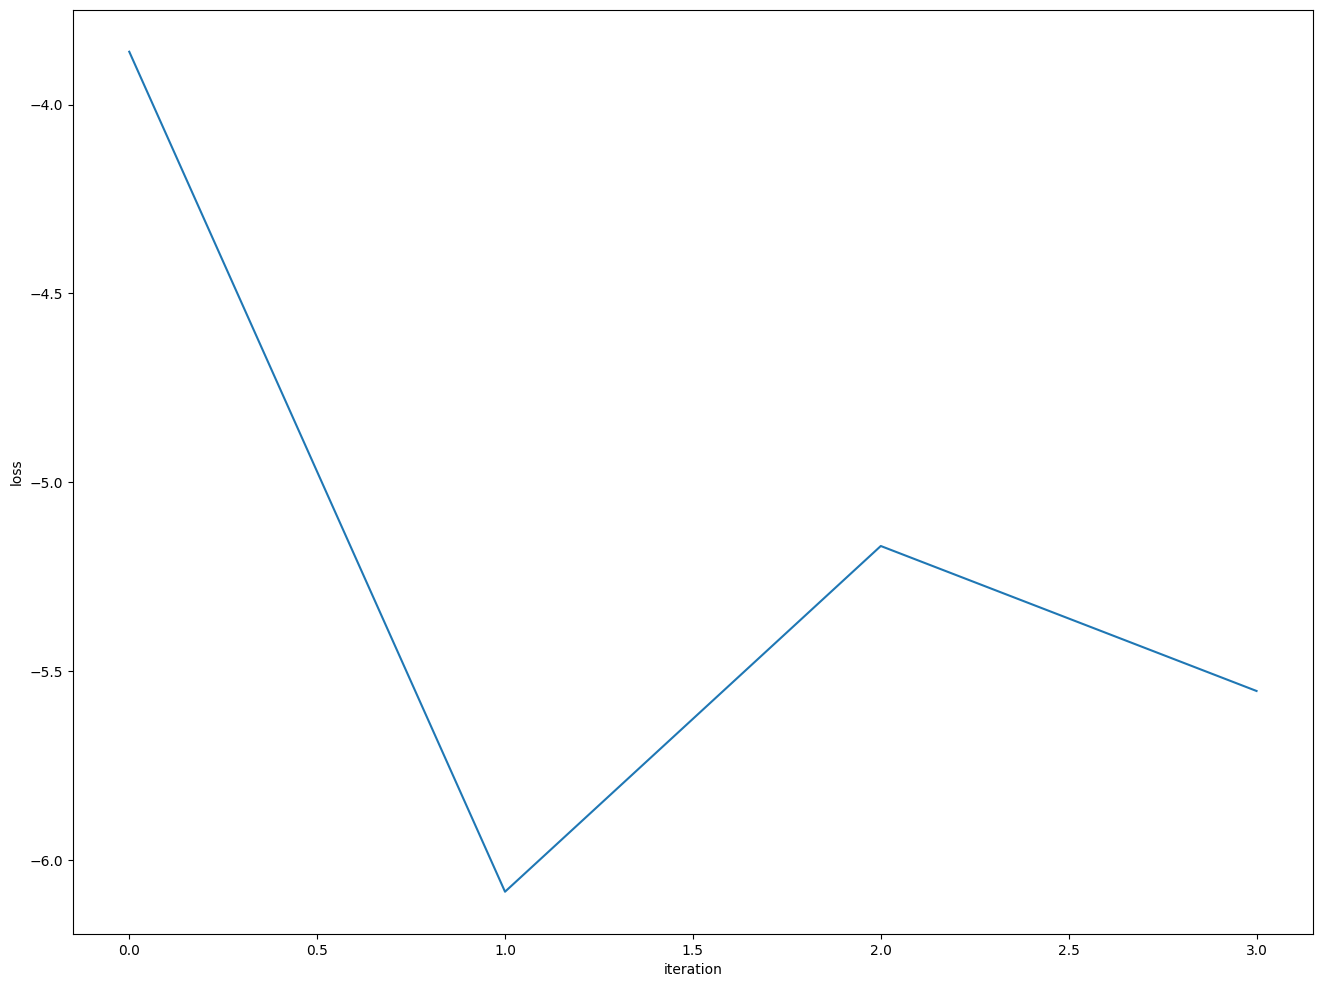

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

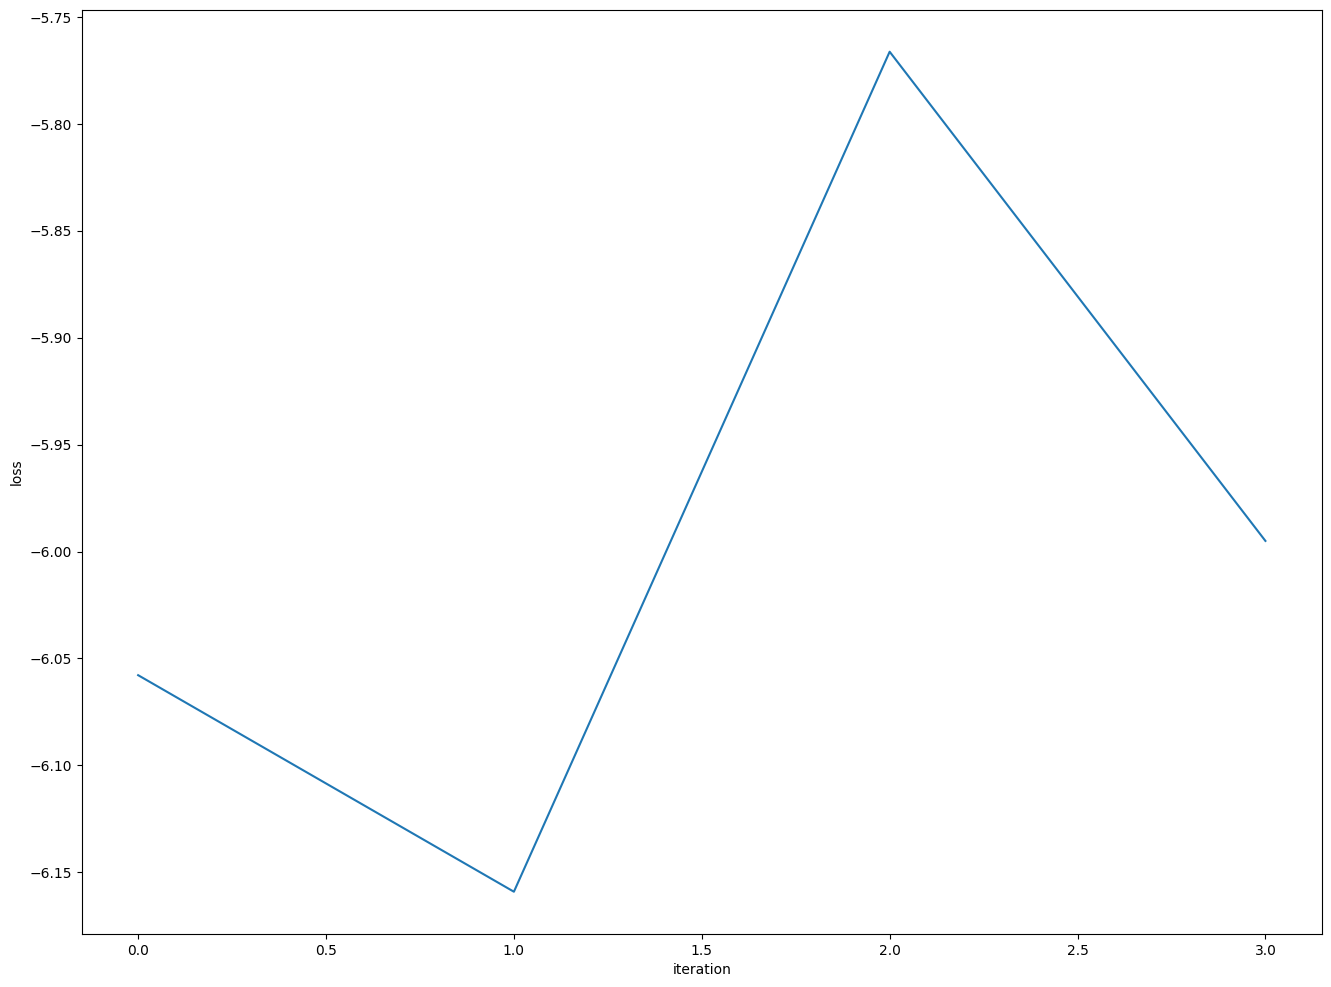

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")